In [ ]:
!pip install pandas requests ortools geopy openpyxl 

# Imports

In [ ]:
import pandas as pd
import requests
import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import googlemaps
import folium
import osmnx as ox
import numpy as np
import networkx as nx
from folium.features import DivIcon

Loading Data from Excel to pd df

In [2]:
print("--- Step 1: Loading Data ---")
file_path = 'data/waybill_1766689335990.xlsx'
df = pd.read_excel(file_path)

--- Step 1: Loading Data ---


c:\Users\issam\Desktop\Files\Trajecta\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df['full_address'] = (
    df['data.toStreet'].astype(str) + ', ' + 
    df['data.toCity'].astype(str) + ', ' + 
    df['data.toState'].astype(str) + ', France'
)

depot_address_str = "18 Rue du 8 Mai 1945, 33150 Cenon, Gironde, France"
depot_row = pd.DataFrame([{'full_address': depot_address_str}])
df = pd.concat([depot_row, df], ignore_index=True)


df = df.map(lambda x: x.lower() if isinstance(x, str) else x)
print(f"Data loaded. Total locations (Depot + Customers): {len(df)}")
df['full_address'].head()

Data loaded. Total locations (Depot + Customers): 97


0    18 rue du 8 mai 1945, 33150 cenon, gironde, fr...
1    13 route des ecoles, fargues st hilaire, giron...
2    38 bis route des écoles, fargues st hilaire, g...
3    14 rue de la relle sud, fargues-saint-hilaire,...
4    26 lotissement le bocage 26, fargues st hilair...
Name: full_address, dtype: object

Step 2 : GEOCODING (Address -> Lat/Lon)

In [ ]:
API_KEY = 'GOOGLE_MAPS_API_KEY' 

# Initialize the client
gmaps = googlemaps.Client(key=API_KEY)

# The address to lookup
def get_lat_lon(address):
    try:
        results = gmaps.geocode(address)
        if results:
            location = results[0]['geometry']['location']
            return pd.Series([location['lat'], location['lng']])
    except Exception as e:
        print(f"Error occurred for {address}: {e}")
        
    # Return None if no result found or an error occurs
    return pd.Series([None, None])



In [5]:
df[['lat', 'lon']] = df['full_address'].apply(get_lat_lon)

In [ ]:
print(df[['lat', 'lon']])

In [ ]:
"""geolocator = Nominatim(user_agent="my_logistics_app_v1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.1)
cache = {}

def get_location(row):
    address = row['full_address']
    # First try: Full precise address
    try:
        location = geocode(address)
        if location:
            return location.latitude, location.longitude
    except:
        pass # If it fails, ignore and try the next step

    # Second try: Remove the "Street" part if it's messy, just try City + Zip
    # Or try a simpler cleaning. For now, let's try searching just the City.
    # This is better than nothing, but puts the point in the city center.
    try:
        # Construct a simpler address: City, State, Country
        simple_address = f"{row['data.toCity']}, {row['data.toState']}, France"
        print(f"Retrying with simpler address: {simple_address}")
        location = geocode(simple_address)
        if location:
            return location.latitude, location.longitude
    except:
        return None, None
    
    return None, None"""

In [6]:
df_clean = df.dropna(subset=['lat', 'lon']).reset_index(drop=True)
print(f"Successfully located {len(df_clean)} out of {len(df)} addresses.")

Successfully located 97 out of 97 addresses.


In [7]:
print(df['full_address'][0],df['lon'][0],df['lat'][0])
# -0.4424656535544245, 44.821422848400836 and -0.440551 44.820869

18 rue du 8 mai 1945, 33150 cenon, gironde, france -0.5102122 44.8519668


In [8]:
print(df.columns)

Index(['full_address', 'data.waybillNo', 'data.statusName', 'data.toState',
       'data.toCity', 'data.toArea', 'data.toStreet', 'lat', 'lon'],
      dtype='object')


In [ ]:
!pip install folium

In [ ]:
# 1. Clean data (remove rows where Geocoding failed)
df_clean = df.dropna(subset=['lat', 'lon'])

# 2. Determine center (average of all points)
center_lat = df_clean['lat'].mean()
center_lon = df_clean['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# 3. Add markers with distinct logic for the Depot
for index, row in df_clean.iterrows():
    
    # Check if this row is the Depot (Index 0)
    if index == 0:
        icon_color = "red"
        icon_type = "home"
        tooltip_text = "DEPOT (Start)"
    else:
        icon_color = "blue"
        icon_type = "info-sign"
        # Handle cases where waybillNo might be missing/NaN
        tooltip_text = str(row.get('data.waybillNo', 'Order'))

    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=row['full_address'],
        tooltip=tooltip_text,
        icon=folium.Icon(color=icon_color, icon=icon_type)
    ).add_to(m)
m.save('route_map.html')
m

Depot located at: (np.float64(44.8519668), np.float64(-0.5102122))


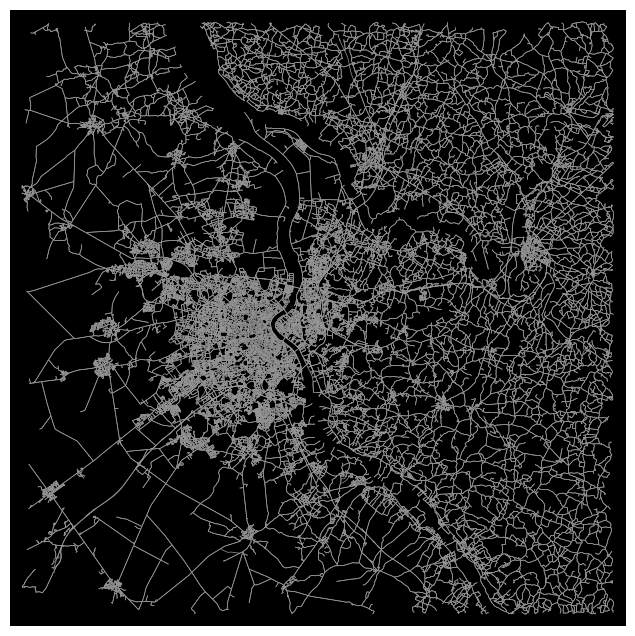

In [ ]:
# 1. Define 'start' using the Depot (Index 0)
start_lat = df.iloc[0]['lat']
start_lon = df.iloc[0]['lon']
start = (start_lat, start_lon)

print(f"Depot located at: {start}")

# 2. Calculate the margin (dist) needed to cover all customers
# We find the furthest point from the depot and add a buffer (e.g., 2km)
# (Rough estimation: 1 degree lat/lon ~= 111km)
max_dist_degrees = max(
    np.abs(df['lat'] - start_lat).max(),
    np.abs(df['lon'] - start_lon).max()
)
# Convert degrees to meters roughly (111,000 meters per degree)
required_dist = (max_dist_degrees * 111000) + 2000 # Add 2km buffer
print(f"Downloading graph with radius: {int(required_dist)} meters...")

# 3. Get the graph centered on Depot with dynamic size
G = ox.graph_from_point(start, dist=required_dist, network_type="drive")

# 4. Add speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# 5. Plot the graph
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=0, edge_linewidth=0.5, figsize=(16,8))

In [14]:
# 1. Get the nearest node for every row in the dataframe (including Depot)
# We pass the entire 'lon' (x) and 'lat' (y) columns at once
print("Mapping GPS coordinates to the nearest road nodes...")
df["node"] = ox.distance.nearest_nodes(G, df['lon'], df['lat'])

# 2. Update the 'start_node' variable
# Since we know the Depot is at Index 0, we just grab that specific node
start_node = df.iloc[0]['node']

# 3. Drop duplicate nodes
# If a customer is at the exact same node as another (or the depot), keep only the first one.
# keep='first' guarantees the Depot (Index 0) is never deleted.
df = df.drop_duplicates("node", keep='first')

# 4. CRITICAL: Reset the Index
# OR-Tools requires strict sequential indexing (0, 1, 2...). 
# If we don't do this, the solver will crash on the "missing" rows we just dropped.
df = df.reset_index(drop=True)

# 5. View the result
print(f"Total unique locations to visit: {len(df)}")
df.head()

Mapping GPS coordinates to the nearest road nodes...
Total unique locations to visit: 92


,full_address,data.waybillNo,data.statusName,data.toState,data.toCity,data.toArea,data.toStreet,lat,lon,node
0,"18 rue du 8 mai 1945, 33150 cenon, gironde, fr...",NaN,NaN,NaN,NaN,NaN,NaN,44.851967,-0.510212,260954736
1,"13 route des ecoles, fargues st hilaire, giron...",gffr25351005883245,succès,gironde,fargues st hilaire,NaN,13 route des ecoles,44.821152,-0.440472,4368077457
2,"38 bis route des écoles, fargues st hilaire, g...",gffr25346008071123,succès,gironde,fargues st hilaire,NaN,38 bis route des écoles,44.820463,-0.436232,831032475
3,"14 rue de la relle sud, fargues-saint-hilaire,...",gffr25349071270029,succès,gironde,fargues-saint-hilaire,NaN,14 rue de la relle sud,44.823253,-0.439287,4368078793
4,"26 lotissement le bocage 26, fargues st hilair...",gffr25351030793741,succès,gironde,fargues st hilaire,NaN,26 lotissement le bocage 26,44.823178,-0.432914,9930429820


In [ ]:
# 1. Define the distance function
def f(a, b):
    try:
        # We use 'travel_time' so the result is in SECONDS
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

# 2. Calculate the Matrix
# df['node'] now contains [Depot, Customer1, Customer2...]
print(f"Calculating travel times for {len(df)} locations... (This may take a moment)")

distance_matrix = np.asarray([[f(a, b) for b in df["node"].tolist()] for a in df["node"].tolist()])

# 3. Create the DataFrame
distance_matrix = pd.DataFrame(distance_matrix, columns=df["node"].values, index=df["node"].values)

# --- NEW: SAFETY CLEANUP FOR OR-TOOLS ---
# Fill unreachable routes with a huge number so the solver avoids them
distance_matrix = distance_matrix.fillna(999999)

# Round to nearest second and convert to Integer (Solver requires Ints)
distance_matrix = distance_matrix.round().astype(int)
# ----------------------------------------

print("Distance Matrix ready and cleaned.")
distance_matrix.head()

Calculating travel times for 92 locations... (This may take a moment)
Distance Matrix ready and cleaned.


,260954736,4368077457,831032475,4368078793,9930429820,1663230514,1854475720,13273635655,1782562635,1848466190,...,3151613571,3151613578,5247469777,5247469766,601108295,601104731,2678322324,3138719571,1395768639,260357745
260954736,0,442,486,468,512,509,719,752,818,785,...,1005,983,1053,1040,1020,877,854,887,900,705
4368077457,431,0,44,40,113,165,375,408,474,441,...,661,639,709,696,676,533,510,543,556,361
831032475,475,44,0,56,69,154,364,397,464,430,...,650,628,698,685,665,522,499,532,545,350
4368078793,455,40,56,0,123,125,335,367,434,401,...,621,599,669,656,636,493,470,503,516,321
9930429820,502,113,69,123,0,106,315,348,415,382,...,602,579,650,637,617,474,450,484,496,302


In [ ]:
# 1. Setup Basic Variables
drivers = 1 
lst_nodes = df["node"].tolist()

# The start node is simply the first item in our list (the Depot)
start_node = lst_nodes[0]

print("--- Configuration ---")
print(f"Start Node (Depot): {start_node}")
print(f"Total stops (including depot): {len(lst_nodes)}")
print(f"Drivers: {drivers}")

# 2. Initialize the Routing Manager
# We tell it: 
#   - How many nodes? (len(lst_nodes))
#   - How many vehicles? (drivers)
#   - Where do they start? (Index 0)
manager = pywrapcp.RoutingIndexManager(
    len(lst_nodes), 
    drivers, 
    0  # <--- CRITICAL: Defines Index 0 as the Depot
)

# 3. Create the Routing Model
model = pywrapcp.RoutingModel(manager)

print("Routing Manager & Model initialized.")

--- Configuration ---
Start Node (Depot): 260954736
Total stops (including depot): 92
Drivers: 1
Routing Manager & Model initialized.


In [ ]:
# 1. Define the Callback
def get_distance(from_index, to_index):
    # Convert internal solver index -> DataFrame Row Index (0, 1, 2...)
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    # Return the travel time (seconds) from the matrix
    # We use .iloc because we want to look up by Row Number, not by Node ID name
    return int(distance_matrix.iloc[from_node, to_node])

# 2. Register the Callback
transit_callback_index = model.RegisterTransitCallback(get_distance)

# 3. Set the Cost Function
model.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# 4. Set Search Parameters
parameters = pywrapcp.DefaultRoutingSearchParameters()
# PATH_CHEAPEST_ARC is usually the best balance of speed vs. quality
parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# parameters.time_limit.seconds = 30

print("Solver parameters set.")

Solver parameters set.


In [ ]:
# 1. Setup the Manager
# We rely on the fact that we put the Depot at Index 0 in the previous steps
lst_nodes = df["node"].tolist() 

manager = pywrapcp.RoutingIndexManager(
    len(lst_nodes),            # Number of locations
    1,                         # Number of drivers (1)
    0                          # <--- CRITICAL: Start/End at Index 0 (The Depot)
)

# 2. Create the Model
model = pywrapcp.RoutingModel(manager)

# 3. Define the Distance Callback
def get_distance(from_index, to_index):
    # Convert internal solver index -> DataFrame row number (0, 1, 2...)
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    # Use .iloc to look up the distance by row position
    return int(distance_matrix.iloc[from_node, to_node])

# 4. Register the Callback
transit_callback_index = model.RegisterTransitCallback(get_distance)

# 5. Set the Cost Function (Minimize Travel Time)
model.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# 6. Set Search Parameters
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

print("Solver is fully configured and ready to run.")

Solver is fully configured and ready to run.


In [ ]:
# 1. Run the solver
solution = model.SolveWithParameters(parameters)

if solution:
    index = model.Start(0)
    print('Route for driver (Sequence of Node Indices):')
    
    route_idx = []
    route_time_seconds = 0
    total_distance_meters = 0 
    
    while not model.IsEnd(index):
        # Current Node Index (Solver -> DataFrame Index)
        node_index = manager.IndexToNode(index)
        route_idx.append(node_index)
        
        previous_index = index
        index = solution.Value(model.NextVar(index))
        
        # A. Calculate TIME (Cost) used by the solver
        try:
            route_time_seconds += get_distance(previous_index, index)
        except:
            pass

        # B. Calculate DISTANCE for this specific leg
        # We need to find the specific path the driver takes (fastest) and measure its length
        if not model.IsEnd(index): # Ensure we don't crash on the last step
            try:
                # 1. Get the actual OSM IDs
                from_osm = df.iloc[manager.IndexToNode(previous_index)]['node']
                to_osm = df.iloc[manager.IndexToNode(index)]['node']
                
                # 2. Re-create the path the driver takes (Fastest Path)
                # We use weight='travel_time' to match the solver's decision
                path = nx.shortest_path(G, from_osm, to_osm, weight='travel_time')
                
                # 3. Sum the physical length (meters) of every road segment in that path
                # (G[u][v][0]['length'] gives the length of the edge between two nodes)
                leg_dist = sum(G[u][v][0]['length'] for u, v in zip(path[:-1], path[1:]))
                
                total_distance_meters += leg_dist
            except Exception as e:
                print(f"Warning: Could not calculate distance for leg. {e}")
                pass

    # Add the final return to start
    route_idx.append(manager.IndexToNode(index))

    # --- Print Final Results ---
    print(route_idx)
    print("-" * 30)
    print(f"Stops Visited:      {len(route_idx) - 1}")
    print(f"Total Travel Time:  {round(route_time_seconds / 60, 2)} minutes")
    print(f"Total Distance:     {round(total_distance_meters / 1000, 2)} km")
    print("-" * 30)

else:
    print("No solution found.")

Route for driver (Sequence of Node Indices):
[0, 14, 1, 3, 2, 4, 5, 91, 88, 89, 90, 87, 83, 85, 84, 86, 82, 81, 80, 73, 79, 78, 77, 75, 76, 72, 74, 71, 67, 66, 68, 69, 65, 70, 64, 63, 62, 61, 60, 59, 58, 56, 57, 50, 51, 52, 53, 54, 55, 48, 49, 42, 41, 43, 44, 47, 45, 46, 40, 39, 38, 37, 33, 32, 31, 34, 35, 36, 8, 9, 10, 7, 11, 12, 6, 13, 15, 27, 26, 25, 24, 28, 29, 30, 23, 22, 21, 19, 20, 18, 17, 16, 0]
------------------------------
Stops Visited:      92
Total Travel Time:  165.4 minutes
Total Distance:     112.54 km
------------------------------


In [ ]:
# 1. Initialize Map
# Start at the first node in your route
start_node_id = df.iloc[route_idx[0]]['node']
start_coords = (G.nodes[start_node_id]['y'], G.nodes[start_node_id]['x'])
m = folium.Map(location=start_coords, zoom_start=14)

# 2. Define the path calculation function (Same logic as before)
def get_path_between_nodes(ordered_indices, dataframe):
    lst_paths = []
    for i in range(len(ordered_indices) - 1):
        try:
            from_idx = ordered_indices[i]
            to_idx = ordered_indices[i+1]
            node_a = dataframe.iloc[from_idx]['node']
            node_b = dataframe.iloc[to_idx]['node']
            
            # Calculate shortest path on the graph
            path = nx.shortest_path(G, source=node_a, target=node_b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except Exception:
            continue
    return lst_paths

# 3. Get the list of paths
final_paths = get_path_between_nodes(route_idx, df)

# 4. Plot the routes manually using Folium
print(f"Plotting {len(final_paths)} road segments...")

for path in final_paths:
    # Extract the (Lat, Lon) coordinates for every node in the path
    # G.nodes[node_id]['y'] is Latitude
    # G.nodes[node_id]['x'] is Longitude
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    
    # Draw the line
    folium.PolyLine(
        locations=route_coords,
        color="blue",
        weight=4,
        opacity=0.7
    ).add_to(m)

# 5. Display map
m.save('optimal_route_map.html')
m

Plotting 92 road segments...


In [ ]:
# We iterate through the route_idx list provided by the solver
# sequence_num: 0, 1, 2... (The order of visit)
# df_index: The actual row number in your dataframe
for sequence_num, df_index in enumerate(route_idx):
    
    # Optional: Skip the very last stop if it is just returning to the depot 
    # (keeps the map cleaner by avoiding two markers on top of each other at the start)
    if sequence_num == len(route_idx) - 1:
        continue

    # 1. Get the Node ID from your dataframe
    node_id = df.iloc[df_index]['node']

    # 2. Get exact coordinates from the Graph G
    # (Using G ensures the marker sits perfectly on the blue road line)
    lat = G.nodes[node_id]['y']
    lon = G.nodes[node_id]['x']

    # 3. Create the Custom Numbered Icon
    # This HTML creates a red circle with white text
    icon_html = f"""
    <div style="
        font-size: 10pt; color: white; background-color: #d9534f;
        border-radius: 50%; text-align: center; line-height: 30px;
        width: 30px; height: 30px; font-weight: bold; border: 2px solid white;
    ">
    {sequence_num + 1}
    </div>
    """

    # 4. Add the Marker to the existing map 'm'
    folium.Marker(
        location=[lat, lon],
        icon=DivIcon(
            icon_size=(30, 30),     # Size of the circle
            icon_anchor=(15, 15),   # Center the number on the coordinate
            html=icon_html
        ),
        popup=f"Stop #{sequence_num + 1}", # Click to see number
        tooltip=f"Stop #{sequence_num + 1}" # Hover to see number
    ).add_to(m)

# 5. Display the final map with lines and numbers
m.save('route_map_with_numbers.html')
m